In [1]:
from __future__ import print_function
import morphs
import scipy as sp
import pandas as pd

%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
import itertools

/usr/local/anaconda/envs/morphs/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
for path in morphs.paths.KS_DF_DIR.glob("*.pkl"):
    num_shuffles = morphs.data.parse.num_shuffles(path)
    print(num_shuffles, path.name)

8 ks_df_8.pkl
64 ks_df_64.pkl
1024 ks_df_1024.pkl
2048 ks_df_2048.pkl


In [3]:
def calc_sig_df(num_shuffles, all_ks_df):
    floor_val = 1.0 / num_shuffles
    all_ks_df.loc[all_ks_df["p"] < floor_val, "p"] = floor_val
    all_ks_df["ks_p_floored"] = all_ks_df["ks_p_unshuffled"]
    all_ks_df.loc[all_ks_df["ks_p_floored"] < floor_val, "ks_p_floored"] = floor_val
    for sym, crit in (("*", 0.05), ("**", 0.01), ("***", 0.001)):
        all_ks_df[sym] = all_ks_df["p"] < crit
        all_ks_df["ks" + sym] = all_ks_df["ks_p_unshuffled"] < crit
    all_ks_df["count"] = 1
    sig_df = all_ks_df.groupby("class").agg("sum")
    sig_df["floor_count"] = (
        all_ks_df[all_ks_df["p"] <= floor_val].groupby("class").agg("sum")["count"]
    )
    return sig_df, floor_val

In [4]:
for path in morphs.paths.KS_DF_DIR.glob("*.pkl"):
    num_shuffles = morphs.data.parse.num_shuffles(path)
    all_ks_df = morphs.load.ks_df(num_shuffles)
    sig_df, floor_val = calc_sig_df(num_shuffles, all_ks_df)
    print(sig_df)

                    ks_p_shuffled  ks_stat_unshuffled  ks_p_unshuffled  \
class                                                                    
diff training cond      45.957414           28.751953        22.449216   
naive                   78.051270           47.765625        39.299355   
same training cond      21.442262           14.041992         6.829091   
self                    11.548666            4.783203         5.592820   

                         p  ks_p_floored    *   ks*   **  ks**  ***  ks***  \
class                                                                        
diff training cond  18.125     27.592639  0.0  40.0  0.0  31.0  0.0   24.0   
naive               22.750     49.694989  0.0  87.0  0.0  64.0  0.0   24.0   
same training cond   5.875     10.149538  0.0  26.0  0.0  13.0  0.0    7.0   
self                 2.500      6.646834  0.0   9.0  0.0   3.0  0.0    0.0   

                    count  floor_count  
class                                   
diff

In [5]:
def plot_neurometric_p_values(all_ks_df, sig_df, floor_val, y="p", log_y=True, ax=None):
    class_order = ["naive", "diff training cond", "same training cond", "self"]
    sns.set(font_scale=1.5)
    sns.set_style("whitegrid")
    if not ax:
        f = plt.figure(figsize=(16, 5))
        ax = f.gca()
    if log_y:
        ax.set_yscale("log")
    plt.yticks([1, 0.05, 0.01, 0.001], ["1", ".05", ".01", ".001"])
    g = sns.swarmplot(data=all_ks_df, x="class", order=class_order, y=y, size=5, ax=ax)

    if y is "p":
        for i, cls in enumerate(class_order):
            if cls in sig_df.index:
                if sig_df.loc[cls, "floor_count"] > 0:
                    label = "%d/%d" % (
                        sig_df.loc[cls, "floor_count"],
                        sig_df.loc[cls, "count"],
                    )
                    ax.annotate(
                        label,
                        xy=(0.1 + i, floor_val * 1.1),
                        arrowprops=dict(arrowstyle="->", color="k"),
                        xytext=(0.2 + i, floor_val * 2.0),
                    )
    ax.set_title("probability of fitting neuromorphic curves by chance")

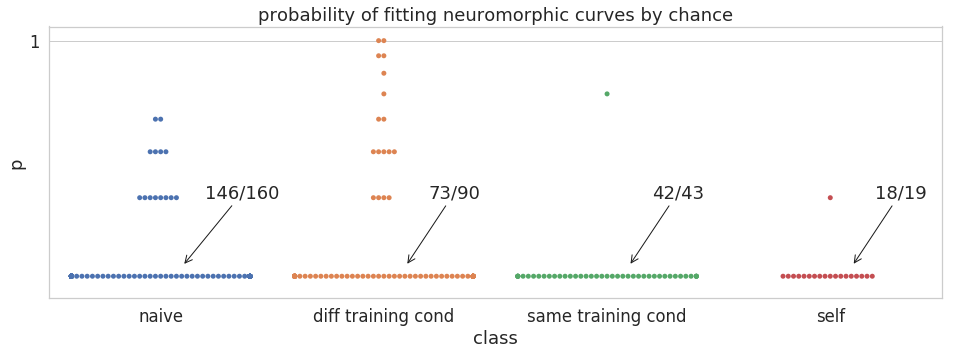

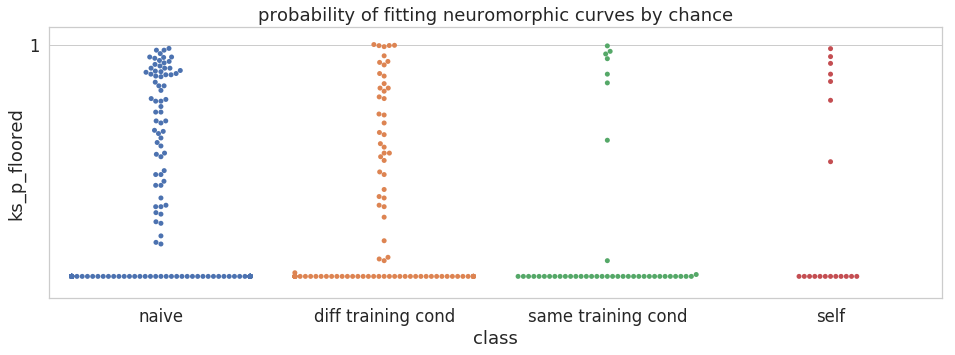

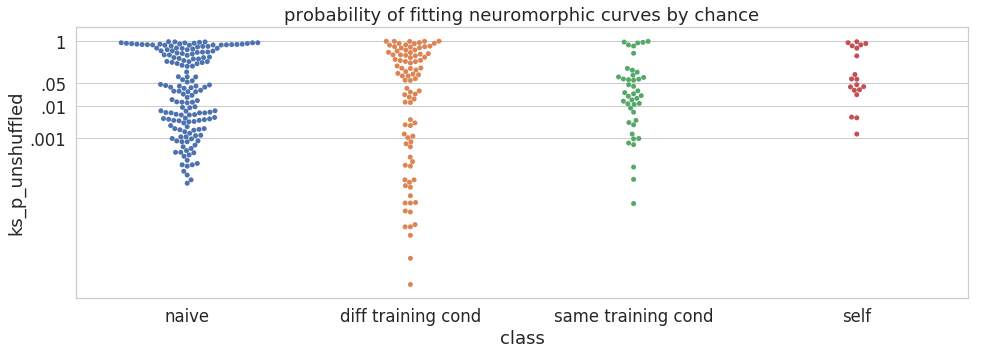

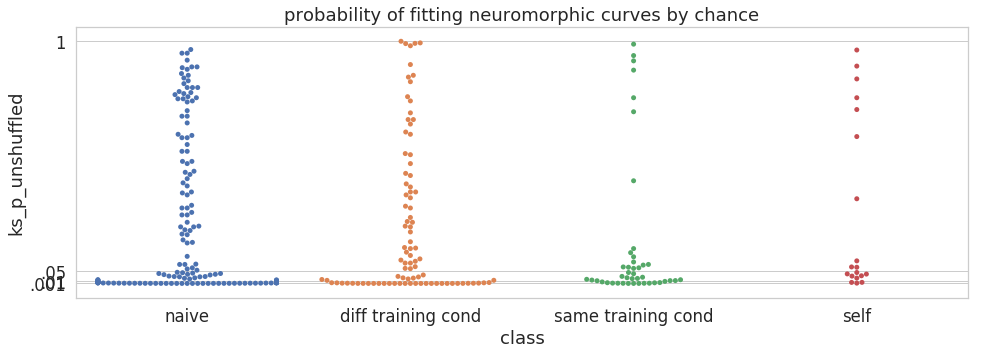

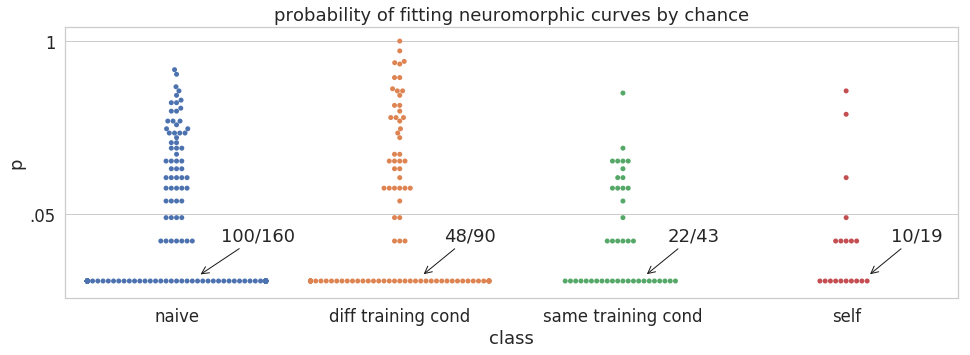

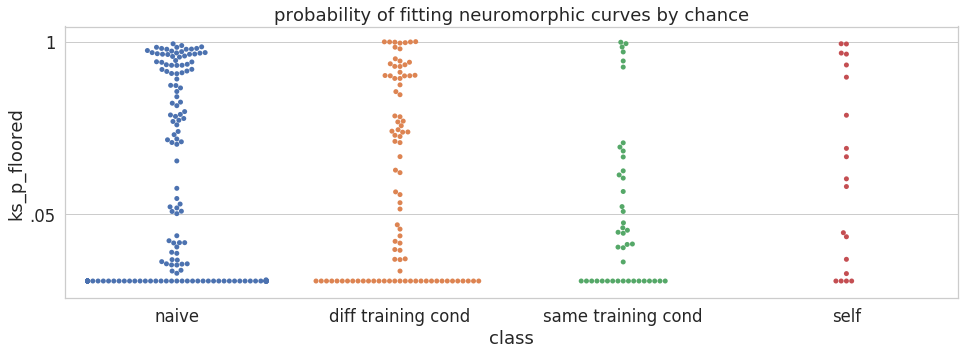

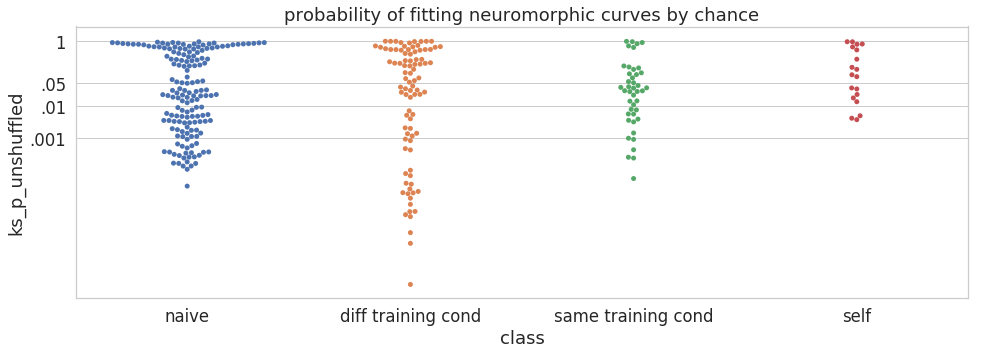

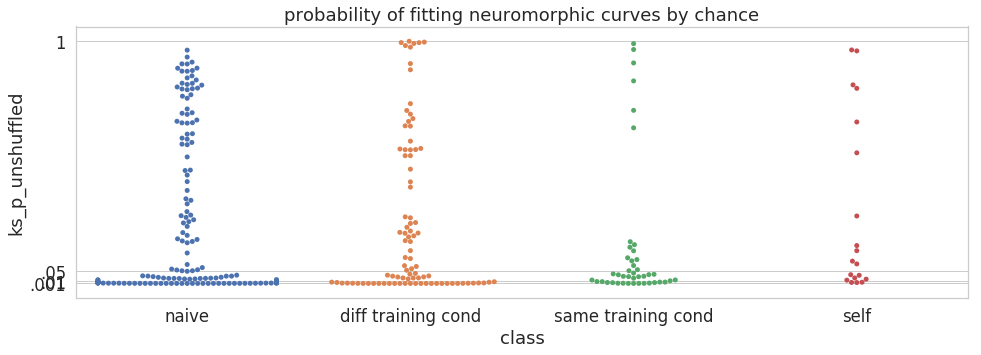

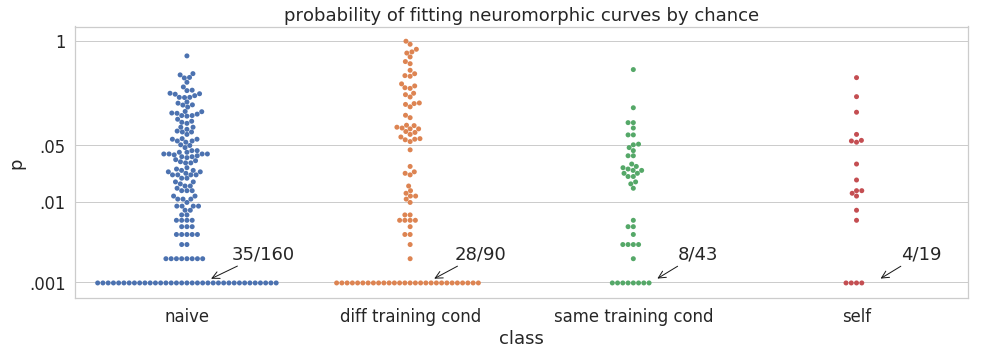

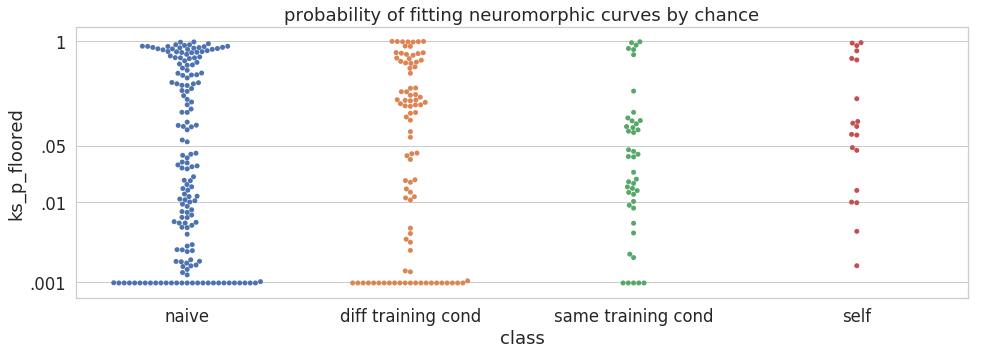

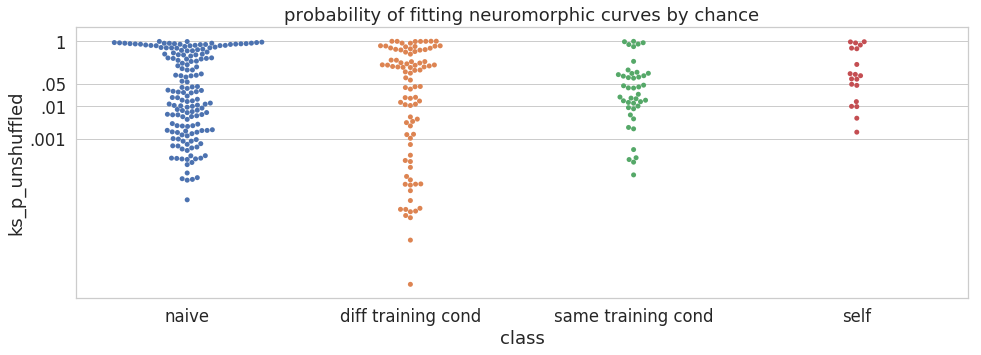

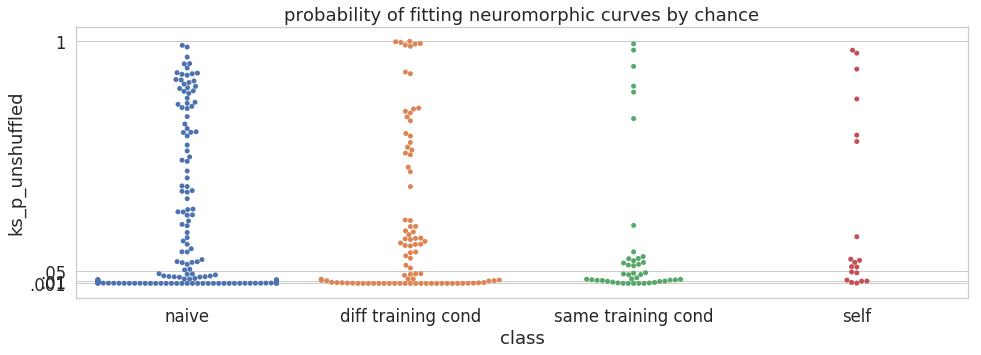

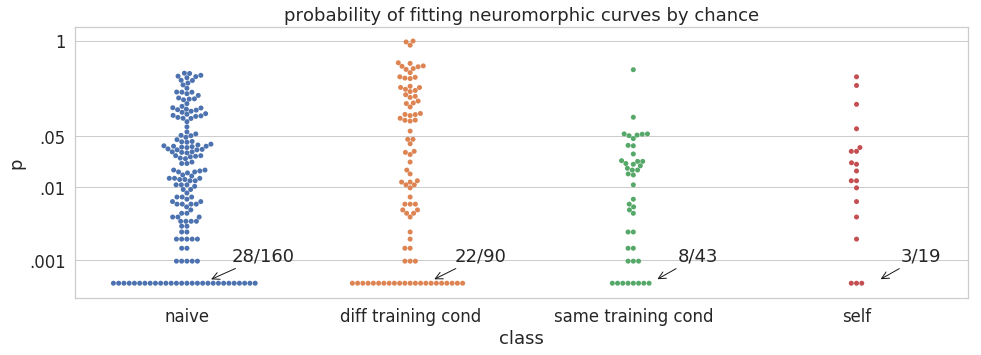

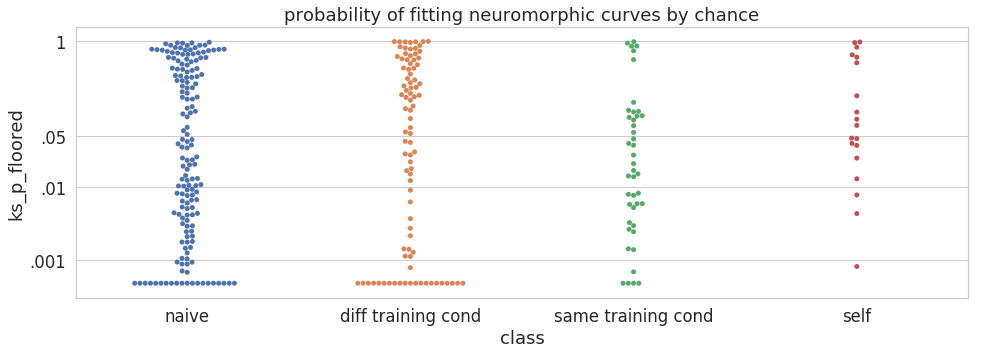

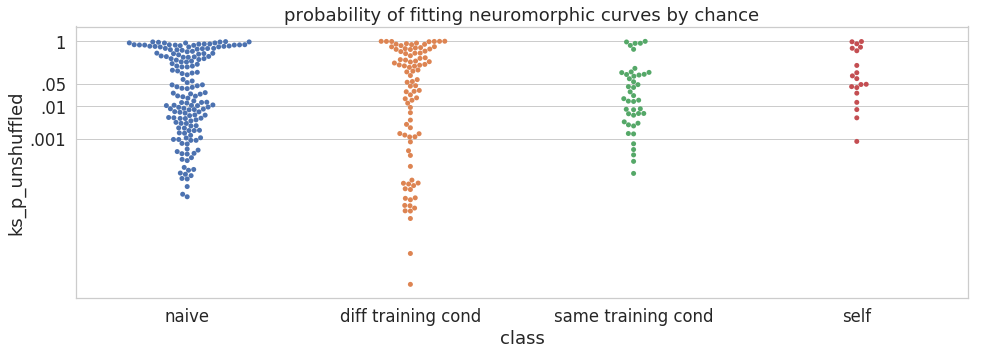

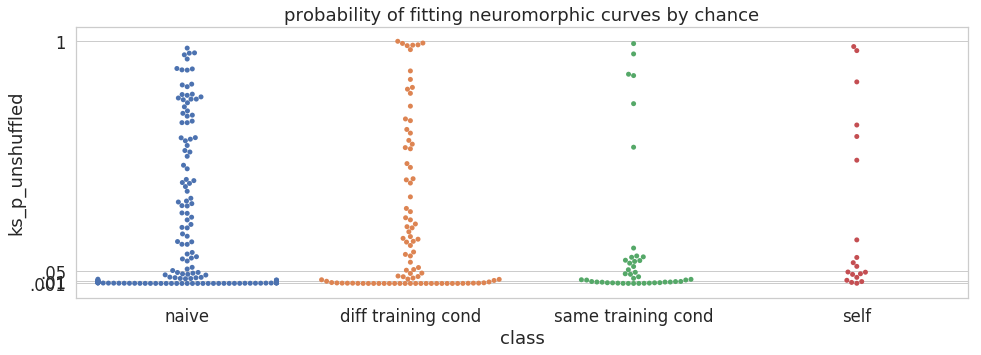

In [6]:
for path in morphs.paths.KS_DF_DIR.glob("*.pkl"):
    num_shuffles = morphs.data.parse.num_shuffles(path)
    all_ks_df = morphs.load.ks_df(num_shuffles)
    sig_df, floor_val = calc_sig_df(num_shuffles, all_ks_df)
    plot_neurometric_p_values(all_ks_df, sig_df, floor_val)
    plot_neurometric_p_values(all_ks_df, sig_df, floor_val, y="ks_p_floored")
    plot_neurometric_p_values(all_ks_df, sig_df, floor_val, y="ks_p_unshuffled")
    plot_neurometric_p_values(
        all_ks_df, sig_df, floor_val, y="ks_p_unshuffled", log_y=False
    )

In [7]:
def pairwise_sig(all_ks_df, on="p"):
    gb = all_ks_df.groupby("class")
    for cls1, cls2 in itertools.combinations(gb.groups.keys(), 2):
        d, p = sp.stats.mstats.ks_twosamp(
            gb.get_group(cls1)[on].values, gb.get_group(cls2)[on].values
        )
        print(
            cls1,
            "vs",
            cls2,
            "   p =",
            p,
            "    bonferonni p =",
            p * len(list(itertools.combinations(gb.groups.keys(), 2))),
        )

In [8]:
for path in morphs.paths.KS_DF_DIR.glob("*.pkl"):
    num_shuffles = morphs.data.parse.num_shuffles(path)
    all_ks_df = morphs.load.ks_df(num_shuffles)
    for on in ["p", "ks_p_unshuffled"]:
        print(num_shuffles, on)
        pairwise_sig(all_ks_df, on=on)

8 p
self vs naive    p = 0.9999999999999999     bonferonni p = 5.999999999999999
self vs same training cond    p = 0.9999999999999996     bonferonni p = 5.999999999999997
self vs diff training cond    p = 0.89891145686175     bonferonni p = 5.3934687411705
naive vs same training cond    p = 0.9990093980640685     bonferonni p = 5.994056388384411
naive vs diff training cond    p = 0.5253074228604142     bonferonni p = 3.1518445371624852
same training cond vs diff training cond    p = 0.40181905484898056     bonferonni p = 2.4109143290938833
8 ks_p_unshuffled
self vs naive    p = 0.11022553127364458     bonferonni p = 0.6613531876418675
self vs same training cond    p = 0.08278491863184208     bonferonni p = 0.4967095117910525
self vs diff training cond    p = 0.13820584570178837     bonferonni p = 0.8292350742107302
naive vs same training cond    p = 0.029203618795855105     bonferonni p = 0.17522171277513063
naive vs diff training cond    p = 0.048142544591651425     bonferonni p = 0.2

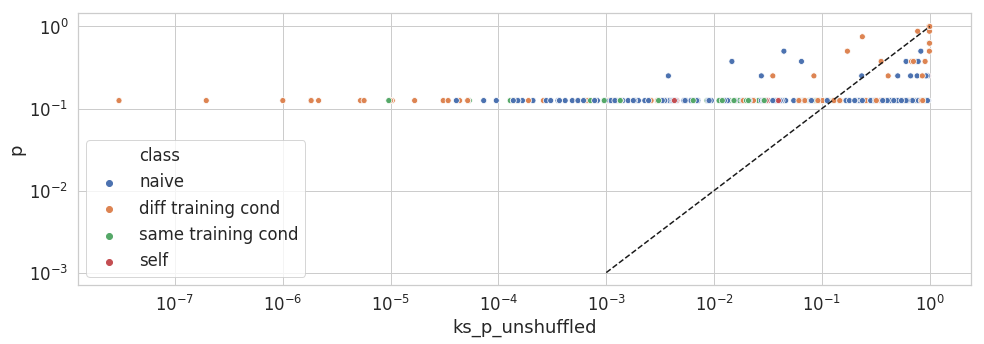

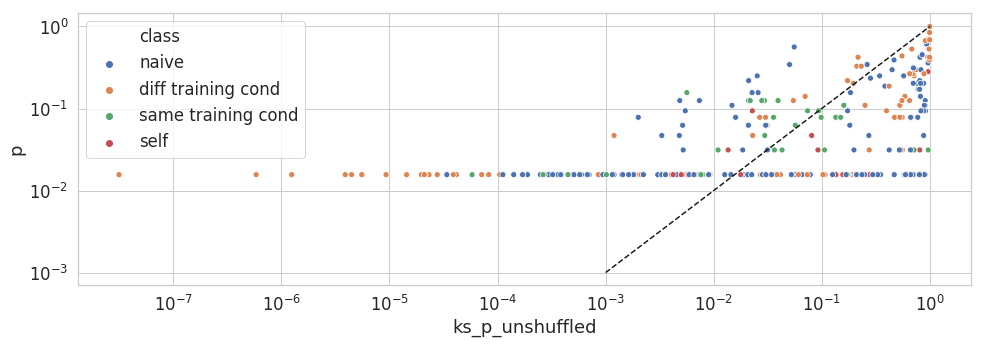

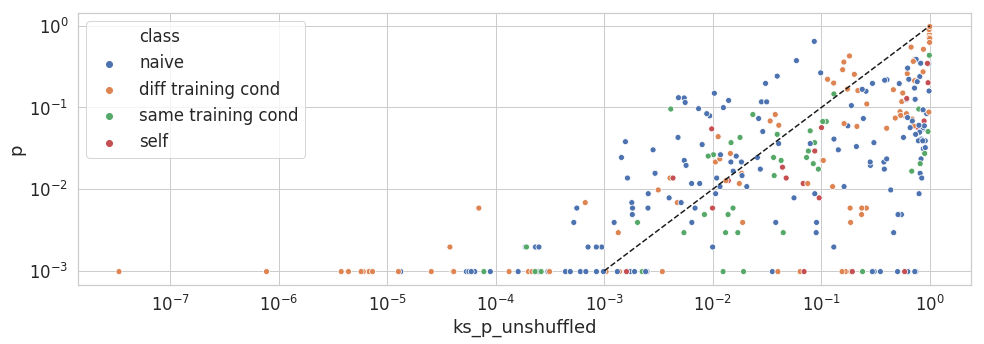

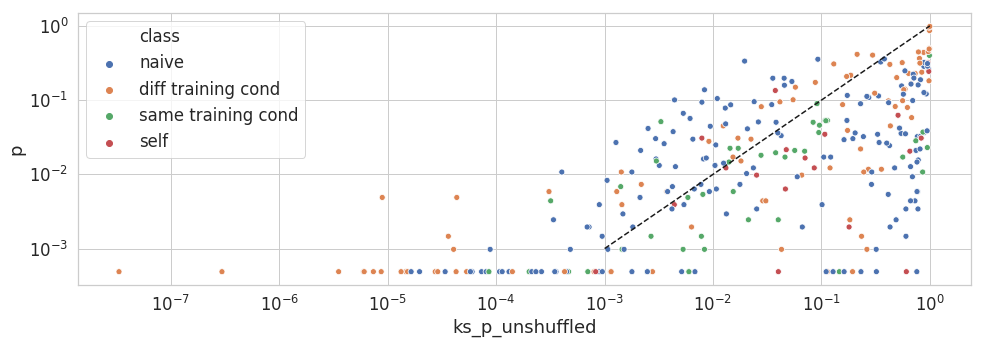

In [9]:
for path in morphs.paths.KS_DF_DIR.glob("*.pkl"):
    class_order = ["naive", "diff training cond", "same training cond", "self"]
    num_shuffles = morphs.data.parse.num_shuffles(path)
    all_ks_df = morphs.load.ks_df(num_shuffles)
    f = plt.figure(figsize=(16, 5))
    ax = f.gca()
    ax.set_yscale("log")
    ax.set_xscale("log")
    sns.scatterplot(
        x="ks_p_unshuffled",
        y="p",
        hue="class",
        hue_order=class_order,
        data=all_ks_df,
        ax=ax,
    )
    unit_line = [1e-3, 1]
    plt.plot(unit_line, unit_line, "k--")